In [1]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# constants:
SUBSAMPLE = 100  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
SUBJECTS = range(1, 2)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
EPOCHS = 5
WINDOW_SIZE = 100

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def prepare_test_data(data_path):
    data = pd.read_csv(data_path)
    return data

In [5]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def train_model(x_train, y_train, model):
    model.fit(x_train, y_train)
    return model

In [8]:
def make_prediction(x_test, model):
    prediction = model.predict_proba(x_test)[:,1]
    return prediction

In [9]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [10]:
def single_metric_auc_score(predictions, y_test, with_plot):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[0]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [11]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [12]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [13]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [14]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return np.array(balance_x), np.array(balance_y)

Train subject 1, class HandStart
HandStart AUC score = 0.987


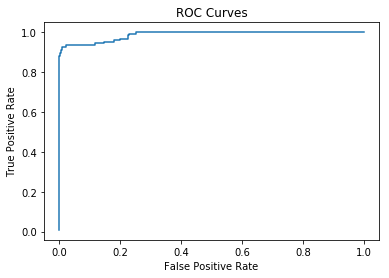

Train subject 1, class FirstDigitTouch
HandStart AUC score = 1.000


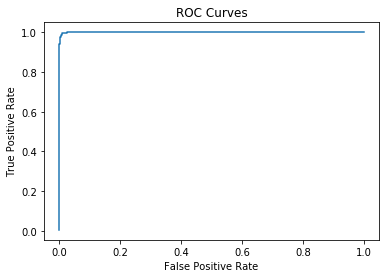

Train subject 1, class BothStartLoadPhase
HandStart AUC score = 1.000


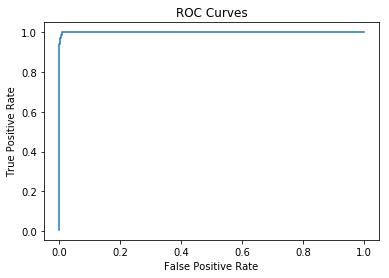

Train subject 1, class LiftOff
HandStart AUC score = 1.000


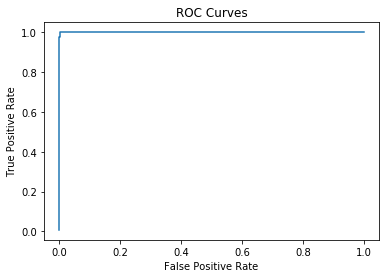

Train subject 1, class Replace
HandStart AUC score = 1.000


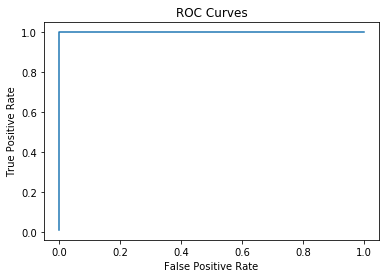

Train subject 1, class BothReleased
HandStart AUC score = 1.000


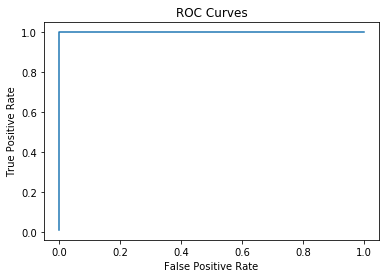

In [92]:
prediction_total = []
test_data_total = []
ids_total = []
for subject in SUBJECTS:
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

  


    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, scaler = scaler_transform(x_raw, None)
    
    x_raw = image_mappping(x_raw[::10], 500)
   
 
    
#     Below you define the model you want to use.
    
    for i in range(N_LABELS):
        logreg = LogisticRegression()
        indices = resample_and_shuffle(y_raw[:,i][::10])
        x_balanced, y_balanced = balance_set(indices, x_raw, y_raw[:,i])

        x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.5)
        predictions = np.empty((y_test.shape[0],6))
        nsamples, nx, ny = x_train.shape
        x_train = x_train.reshape((nsamples,nx*ny))

        nsamples, nx, ny = x_test.shape
        x_test = x_test.reshape((nsamples,nx*ny))

        print('Train subject %d, class %s' % (subject, COLUMNS[i]))
        model = train_model(x_train, y_train, logreg)
        predictions[:,i] = make_prediction(x_test, model)
        single_metric_auc_score(predictions[:,i], y_test, True)
#         test_data_total.append(y_test)   
    prediction_total.append(predictions)

In [95]:
r = pd.DataFrame(prediction_total[0])

In [96]:
r

,0,1,2,3,4,5
0,1.181037e-311,1.179745e-311,7.129367e-321,0.269842,7.134308e-321,1.656774e-05
1,7.139249e-321,1.390532e-01,7.144189e-321,0.156300,7.149130e-321,1.179200e-05
2,7.154071e-321,2.730760e-01,7.159011e-321,0.065035,7.163952e-321,7.519388e-04
3,7.168893e-321,2.181015e-01,7.173833e-321,0.089468,7.178774e-321,6.494439e-03
4,7.183714e-321,2.730760e-02,7.188655e-321,0.184686,7.193596e-321,6.301770e-04
5,7.198536e-321,1.620491e-01,7.203477e-321,0.113901,7.208418e-321,2.032539e-04
6,7.213358e-321,1.519884e-01,7.218299e-321,0.136897,7.223240e-321,2.112677e-04
7,7.228180e-321,2.626560e-01,7.233121e-321,0.144084,7.238062e-321,4.188366e-06
8,7.243002e-321,1.534256e-01,7.247943e-321,0.302899,7.252884e-321,1.212992e-03
9,7.257824e-321,7.976694e-02,7.262765e-321,0.117135,7.267706e-321,2.772316e-06
